<a href="https://colab.research.google.com/github/madelezhia/vision-systems-lab/blob/main/I-Foundations/tlearning_resnet18_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning from pre-trained resnet18 to classify negative vs positive samples of concrete cracks

## Download Data and Imports


In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
!unzip -qo '/gdrive/MyDrive/Colab Notebooks/Portfolio/I-Foundations/concrete_crack_images_for_classification.zip'

In [4]:
!pip install torchvision

In [5]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [6]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

## Dataset Class


In [7]:
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="."
        positive="Positive"
        negative="Negative"

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
        positive_files.sort()
        negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
        negative_files.sort()
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0

        if train:
            self.all_files=self.all_files[0:10000] #Change to 30000 to use the full test dataset
            self.Y=self.Y[0:10000] #Change to 30000 to use the full test dataset
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)

    # Get the length
    def __len__(self):
        return self.len

    # Getter
    def __getitem__(self, idx):


        image=Image.open(self.all_files[idx])
        y=self.Y[idx]


        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

Data split


In [8]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform =transforms.Compose([ transforms.ToTensor(), transforms.Normalize(mean, std)])

train_dataset=Dataset(transform=transform,train=True)
validation_dataset=Dataset(transform=transform,train=False)


print("done")

done


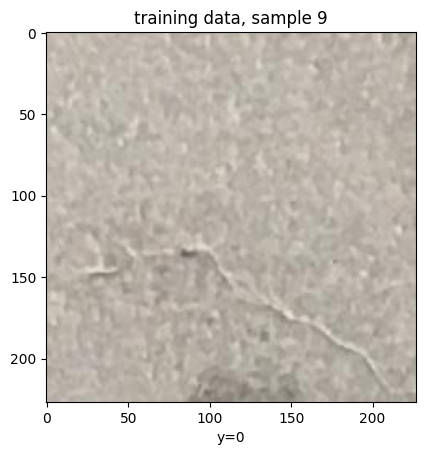

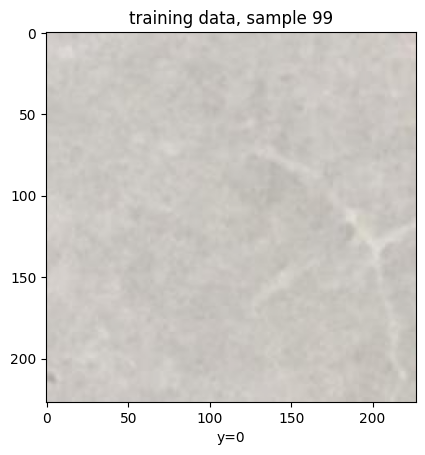

In [9]:
samples = [9,99]
for sample  in samples:
    # Denormalize and convert the tensor to a NumPy array for plotting
    image_tensor = train_dataset[sample][0].permute(1, 2, 0)
    image_numpy = image_tensor.numpy() * std + mean  # Denormalize
    plt.imshow(image_numpy)
    plt.xlabel("y="+str(train_dataset[sample][1].item()))
    plt.title("training data, sample {}".format(int(sample)))
    plt.show()

## Modify a pre-trained resnet18 model


In [10]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 200MB/s]


In [11]:
# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

In [12]:
# Replace the output layer with a new fully connected layer
model.fc = nn.Linear(512, 2)  # 512 inputs (from the last hidden layer) and 2 outputs

In [13]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
import torch.optim as optim
# CrossEntropyLoss for multi-class classification
criterion = nn.CrossEntropyLoss()

# Adam optimizer, only updating the parameters of the final layer (model.fc)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=100, shuffle=False)

In [16]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

## Training, accuracy on the validation data


In [17]:
n_epochs=1
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)
model = model.cuda()
start_time = time.time()

Loss=0
start_time = time.time()

for epoch in range(n_epochs):
    for x, y in train_loader:
        # Move the data to GPU if available
        x, y = x.cuda(), y.cuda()
        model.train()
        #clear gradient
        optimizer.zero_grad()
        #make a prediction
        outputs = model(x)
        # calculate loss
        loss = criterion(outputs, y)
        # calculate gradients of parameters
        loss.backward()
        # update parameters
        optimizer.step()

        loss_list.append(loss.item())

    correct=0
    with torch.no_grad():
      for x_test, y_test in val_loader:
          # Move the data to GPU if available
          x_test, y_test = x.cuda(), y.cuda()
          # set model to eval
          model.eval()
          #make a prediction
          outputs = model(x_test)
          #find max
          _, predicted = torch.max(outputs, 1)

          #Calculate misclassified  samples in mini-batch
          #hint +=(yhat==y_test).sum().item()
          correct += (predicted == y_test).sum().item()
    accuracy=correct/N_test
    accuracy_list.append(accuracy)
    print(f'Epoch {epoch + 1}, Train Loss: {loss.data:.4f}, accuracy: {accuracy:.4f}')




Epoch 1, Train Loss: 0.0771, accuracy: 0.9900


In [18]:
accuracy

0.99

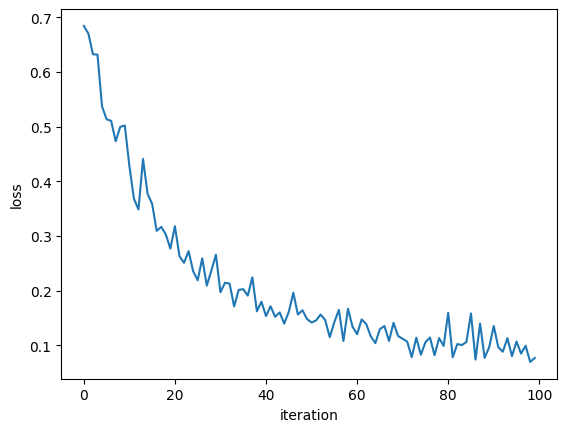

In [19]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


## Misclassified samples


In [20]:
misclassified_samples = []

with torch.no_grad():
    for i, (x_val, y_val) in enumerate(val_loader):
        x_val, y_val = x_val.cuda(), y_val.cuda()

        outputs = model(x_val)
        _, predicted = torch.max(outputs, 1)

        # Identify misclassified
        misclassified_indices = (predicted != y_val).nonzero(as_tuple=False).view(-1)

        # get global indices of misclassified items and their values
        #print(misclassified_indices)
        if misclassified_indices.numel() > 0:
          for idx in misclassified_indices:
              sample_index = i * val_loader.batch_size + idx.item()
              pred_value = predicted[idx].unsqueeze(0).cpu()
              actual_value = y_val[idx].unsqueeze(0).cpu()
              misclassified_samples.append((sample_index, pred_value, actual_value))

        # Stop when at least 4 errors
        if len(misclassified_samples) >= 4:
            break

# Afficher les 4 premières erreurs
for sample in misclassified_samples[:4]:
    index, pred, actual = sample
    print(f"sample {index} predicted value: {pred}  actual value: {actual}")

sample 40 predicted value: tensor([0])  actual value: tensor([1])
sample 94 predicted value: tensor([0])  actual value: tensor([1])
sample 142 predicted value: tensor([0])  actual value: tensor([1])
sample 226 predicted value: tensor([0])  actual value: tensor([1])
